In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from scripts.core import *

In [3]:
from scripts.learners import ModelLearner, ParallelLearner
from scripts.dataset import CSVData, MovingObjectData, SingleCSV
from scripts.loss import weightedMSE
import pickle
from scripts.utils import *

As loading and cleaning the dataset takes some time, we load the dataset and save it in a pickle file to be loaded below. This makes the process of loading the dataset quicker the next time we run the model.

In [8]:
data=MovingObjectData.fromCSVFolder("/home/sufiyan/data/Daimler/100_vids/csv/")
with open("/home/sufiyan/data/Daimler/100_vids/pickled_MovingObject_160_csv_20Feb", 'wb') as f:
    pickle.dump(data, f)

Loading the dataset. To see how the dataset works, see [scripts/dataset.py](https://github.com/dumbPy/MTP/blob/master/scripts/dataset.py)

In [4]:
with open("/home/sufiyan/data/Daimler/100_vids/pickled_MovingObject_160_csv_20Feb", 'rb') as f:
    dataset=pickle.load(f)

Number of files for **Left**, **Right** and **Other** classes respectively. These include flipped files for Left and Right

In [5]:
print(len([1 for x,y in dataset if y==0]))
print(len([1 for x,y in dataset if y==1]))
print(len([1 for x,y in dataset if y==2]))

61
61
39


Plotting a random datafile to show what we are using in the training data. We are only considering Moving Object tracking details and Vehicle Motion data columns.

In [6]:
dataset[0][0]

array([[ 0.10646, -0.83791,  0.99698, -0.27235, -1.49996],
       [ 0.10646, -0.83791,  0.99698, -0.27235, -1.49996],
       [ 0.10646, -0.83791,  0.99698, -0.27235, -1.49996],
       ...,
       [ 0.10646, -0.95347, -1.29007,  1.10821, -2.59574],
       [ 0.10646, -0.95347, -1.29007,  1.10821, -2.59574],
       [ 0.10646, -0.95347, -1.29007,  1.10821, -2.0416 ]])

Reason for Braking:  Driving/Moving Object


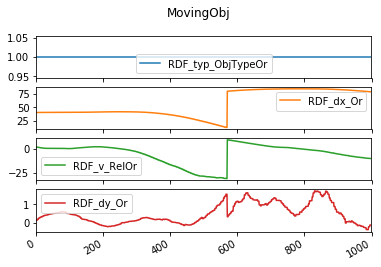

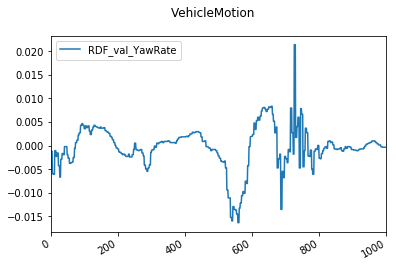

In [7]:
dataset.plot(50)

Seperating train and test files.

In [8]:
np.random.seed(10) #seting seed for always selecting same train and test set
totalFiles=len(dataset)
testFiles=np.random.choice(totalFiles, int(0.2*totalFiles)) #20% files as test files

Defining the Dataloaders for training and validation data

In [9]:
trainLoader=torch.utils.data.DataLoader([(x,y) for i,(x,y) in enumerate(dataset) if not i in testFiles])
testLoader=torch.utils.data.DataLoader([(x,y) for i,(x,y) in enumerate(dataset) if i in testFiles])

A simple model defined below is trained. It consists of a 2 Layer LSTM followed by a fully connected Layer

In [10]:
class CSVmodel(nn.Module):
    def __init__(self,categories=3, input_size=5, hidden_size=10, dropout=0.1):
        super().__init__()
        self.l1=nn.LSTM(input_size=input_size,hidden_size=hidden_size, dropout=dropout, num_layers=2)
        self.l2=nn.Linear(in_features=hidden_size,out_features=categories)
        self.softmax=nn.Softmax()
    def forward(self,x):
        x,_=self.l1(x)
        x=x[:,-1,:]
        x= self.l2(x)
        return x

ParallelLearner class takes ModelLearners that take models and other parameters like learning rate, optimization function and loss function.

In [11]:
learner=ParallelLearner([
                ModelLearner(CSVmodel(), lr=0.001, loss_fn=torch.nn.MSELoss, 
                             optim=torch.optim.SGD, modelName='movingObjectDataModel' ),
                ModelLearner(CSVmodel(), lr=0.001, loss_fn=torch.nn.CrossEntropyLoss, 
                             optim=torch.optim.SGD, modelName='movingObjectDataModel' ),
                ModelLearner(CSVmodel(), lr=0.001, loss_fn=partial(weightedMSE, [2,2,1]), 
                              optim=torch.optim.SGD, modelName='movingObjectDataModel' ),
                ModelLearner(CSVmodel(), lr=0.001, loss_fn=partial(weightedMSE, [1,1,2]), 
                             optim=torch.optim.SGD, modelName='movingObjectDataModel' ),
                ],
        epochs=10, trainLoader=trainLoader, validLoader=testLoader)

The ParallelLearner trains all the models parallelly by using the same data

In [12]:
learner.train(200)

Plotting the loss for all the 4 models above. 

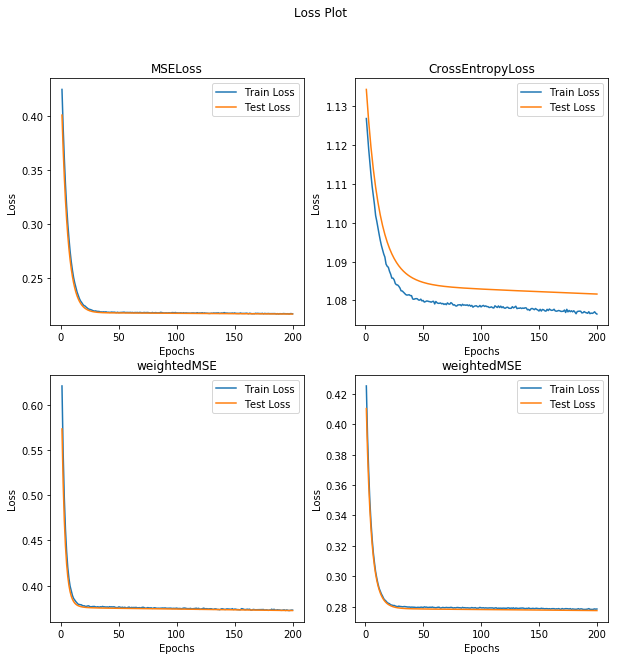

In [13]:
learner.plotLoss(figsize=(10,10))

Plotting confusion matrix for training dataset for all the four loss functions namely weighted_MSE (1,1,0.1), weighted_MSE(0.5, 0.5, 0.1), MSE and CrossEntropyLoss.

In [14]:
print("MSE"); print(learner.learners[0].train_confusion_matrix_list[-1])
print("CE"); print(learner.learners[1].train_confusion_matrix_list[-1])
print("wMSE_2:2:1"); print(learner.learners[2].train_confusion_matrix_list[-1])
print("wMSE_1:1:2"); print(learner.learners[3].train_confusion_matrix_list[-1])

MSE
[[48  3  0]
 [41  8  0]
 [28  4  0]]
CE
[[51  0  0]
 [49  0  0]
 [32  0  0]]
wMSE_2:2:1
[[40 11  0]
 [33 16  0]
 [28  4  0]]
wMSE_1:1:2
[[44  7  0]
 [30 19  0]
 [29  3  0]]


Confision Matrix for all the loss functions for test data

In [15]:
print("MSE"); print(learner.learners[0].valid_confusion_matrix_list[-1])
print("CE"); print(learner.learners[1].valid_confusion_matrix_list[-1])
print("wMSE_2:2:1"); print(learner.learners[2].valid_confusion_matrix_list[-1])
print("wMSE_1:1:2"); print(learner.learners[3].valid_confusion_matrix_list[-1])

MSE
[[10  0  0]
 [ 8  4  0]
 [ 6  1  0]]
CE
[[10  0  0]
 [12  0  0]
 [ 7  0  0]]
wMSE_2:2:1
[[ 3  7  0]
 [ 2 10  0]
 [ 2  5  0]]
wMSE_1:1:2
[[10  0  0]
 [ 6  6  0]
 [ 5  2  0]]


The Models seems to perform even worse on **Left** and **Right** data files after adding **VehicleMotion**.

### Trying to find other relavent columns for steering angle

Added **diff** column that is smoothed difference between **BS_v_EgoFAxleLeft_kmh** and **BS_v_EgoFAxleRight_kmh**

Reason for Braking:  Driving/Moving Object


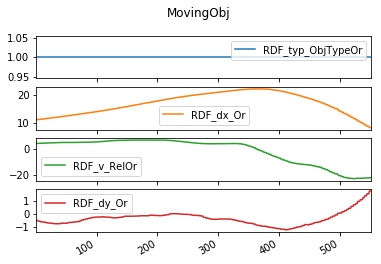

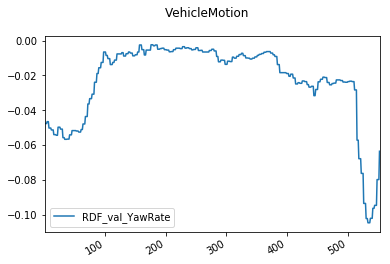

In [16]:
dataset.plot(0)

In [17]:
for x,y in trainLoader:
    print(x, y); break

tensor([[[-3.8719, -1.2981,  0.6066,  0.0399,  0.0916],
         [-3.8719, -1.2981,  0.6066,  0.0399,  0.2375],
         [-3.8719, -1.2981,  0.6066,  0.0399,  0.2375],
         ...,
         [-3.8719,  1.7506,  0.9406, -0.8593,  2.4123],
         [-3.8719,  1.7506,  0.9406, -0.8593,  2.4123],
         [-3.8719,  1.7506,  0.9406, -0.8593,  2.4123]]], dtype=torch.float64) tensor([2])


diff column is basically **BS_v_EgoFAxleLeft_kmh** **-** **BS_v_EgoFAxleRight_kmh** and smoothened with gaussian 1D filter. Looks like the opposite of this substraction is **RDF_val_YawRate**.

Hence, now we know what **RDF_val_YawRate** column represents.

### Let's try to see if we can find other columns with some Angle

In [18]:
df=read_csv_auto(dataset.files[0])

In [19]:
[col for col in df.columns if "Angle" in col and "Yaw" in col]

['MPC_val_YawAngleLt',
 'MPC_val_YawAngleLt_Status',
 'MPC_val_YawAngleLtMC',
 'MPC_val_YawAngleLtMC_Status',
 'MPC_val_YawAngleRt',
 'MPC_val_YawAngleRt_Status',
 'MPC_val_YawAngleRtMC',
 'MPC_val_YawAngleRtMC_Status',
 'GPP_C_erb_YawAngleLt',
 'GPP_C_erb_YawAngleRt']

In [ ]:
f,(ax1,ax2)=plt.subplots(2,1,figsize=(6,3), sharex=True)
df["BSM_ang_WheelAngle"].plot(ax=ax1)
df["RDF_val_YawRate"].plot(ax=ax2)

I was trying to find if there are any other columns that represent steering angle better. But looks like **RDF_val_YawRate** is the only one.

I will try to eliminate columns **BS_v_EgoFAxleLeft_kmh** and **BS_v_EgoFAxleRight_kmh** and see if it helps